In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

In [2]:
yield_df = pd.read_csv("../data/train_data/yield_data.csv")
yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13130 entries, 0 to 13129
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           13130 non-null  object 
 1   Item                           13130 non-null  object 
 2   Year                           13130 non-null  int64  
 3   average_rain_fall_mm_per_year  13130 non-null  float64
 4   avg_temp                       13130 non-null  float64
 5   hg/ha_yield_log                13130 non-null  float64
 6   pesticides_tonnes_log          13130 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 718.2+ KB


## CLUSTERING CLIMATIQUE

---

- Nous pouvons regroupe els pays selon :
  - Pluie moyenne, température moyenne, taux de pesticides moyens

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [4]:
country_stats = yield_df.groupby('Area')[["average_rain_fall_mm_per_year", "avg_temp", "pesticides_tonnes_log"]].mean()
country_stats.head()

,average_rain_fall_mm_per_year,avg_temp,pesticides_tonnes_log
Area,,,
Albania,1485.0,16.300101,6.098416
Algeria,89.0,17.484825,7.643440
Angola,1010.0,24.311341,3.848428
Argentina,591.0,17.708478,10.997024
Armenia,562.0,9.580952,4.481621


In [5]:
# Standardisons les données puis choisons le meilleur k
scaler = StandardScaler()
X_country_stats = scaler.fit_transform(country_stats)

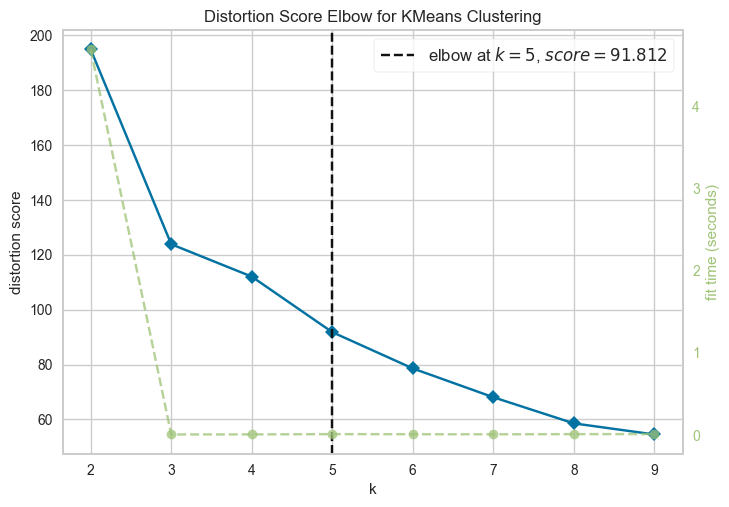

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
kmeans = KMeans(random_state = 404)
visualizer = KElbowVisualizer(kmeans, k=(2,10), force_model=True)
visualizer.fit(X_country_stats)
visualizer.show()

In [7]:
kmeans = KMeans(n_clusters=5, random_state=42)
country_stats["climate_cluster"] = kmeans.fit_predict(X_country_stats)

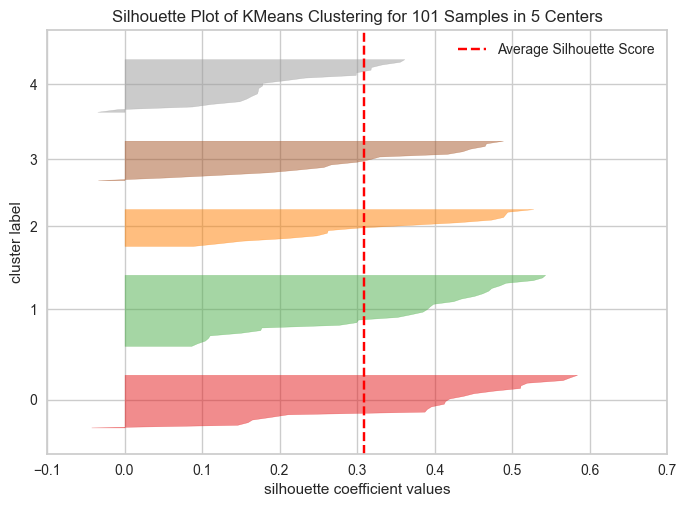

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 101 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [8]:
# Visualisation des differents cluster
viz = SilhouetteVisualizer(kmeans, force_model=True)
viz.fit(X_country_stats)
viz.show()

In [9]:
print('*************************Les pays par cluster**************************************')
for i in range (5):
  print(f"Cluster {i} :")
  print((country_stats[country_stats["climate_cluster"] == i].index).values.tolist())
  print("-"*100)

*************************Les pays par cluster**************************************
Cluster 0 :
['Bangladesh', 'Cameroon', 'Colombia', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 'Guinea', 'Guyana', 'Honduras', 'Indonesia', 'Jamaica', 'Malaysia', 'Mauritius', 'Nicaragua', 'Papua New Guinea', 'Peru', 'Sri Lanka', 'Sudan', 'Suriname', 'Thailand']
----------------------------------------------------------------------------------------------------
Cluster 1 :
['Armenia', 'Austria', 'Belarus', 'Belgium', 'Bulgaria', 'Canada', 'Chile', 'Croatia', 'Denmark', 'Estonia', 'Finland', 'Germany', 'Hungary', 'Ireland', 'Kazakhstan', 'Latvia', 'Lithuania', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Romania', 'Slovenia', 'Sweden', 'Switzerland', 'Tajikistan', 'Ukraine', 'United Kingdom']
----------------------------------------------------------------------------------------------------
Cluster 2 :
['Argentina', 'Australia', 'Brazil', 'France', 'Greece', 'India', 'Italy', 'Jap

* Cluster 0 - Tropiques humides (pluie élevée, chaleur modérée)
* Cluster 1 - Climat tempéré / froid (Europe, Canada, Nord)
* Cluster 2 - Climat méditerranéen / subtropical (Europe Sud, Amérique Sud)
* Cluster 3 - Zones arides / semi‑arides (Sahel, Golfe, Afrique Sud)
* Cluster 4 - Climat chaud sec / continental (Afrique Nord, Moyen‑Orient, Asie Sud)

In [10]:
# on peux réinjecter ce cluster dans notre dataset principale
#(mais sans oublier de considérer climate_cluster comme categories et faire du onehot sur elle après)
yield_df = yield_df.merge(country_stats["climate_cluster"], on="Area", how="left")

In [11]:
yield_df.head()

,Area,Item,Year,average_rain_fall_mm_per_year,avg_temp,hg/ha_yield_log,pesticides_tonnes_log,climate_cluster
0,Albania,Maize,1990,1485.0,16.37,10.508186,4.804021,4
1,Albania,Potatoes,1990,1485.0,16.37,11.107480,4.804021,4
2,Albania,"Rice, paddy",1990,1485.0,16.37,10.057667,4.804021,4
3,Albania,Sorghum,1990,1485.0,16.37,9.433564,4.804021,4
4,Albania,Soybeans,1990,1485.0,16.37,8.853808,4.804021,4


## Feature Engineering

In [12]:
# Nous allons crée quelques vairables

# quelques indicateurs agro-climatiques (pays_chaud avec peu de pluie)
yield_df['water_stress'] = yield_df['average_rain_fall_mm_per_year'] / yield_df['avg_temp']

# interaction plui*temperature
yield_df["rain_temp_interaction"] = yield_df['average_rain_fall_mm_per_year'] * yield_df['avg_temp']

# intensité d'intrant (car je pense que les pays très arrosés utilisent moind de pesticide)
yield_df["input_intensity"] = yield_df["pesticides_tonnes_log"] / yield_df["average_rain_fall_mm_per_year"]

# interaction pesticides temperature
yield_df["pest_temp_interaction"] = yield_df["pesticides_tonnes_log"] * yield_df["avg_temp"]

## Etude de Dependances

In [13]:
# faisons une petite étude pour voir les variables liée à notre cible
num_vars = yield_df.select_dtypes(include=np.number).columns.tolist()
num_vars.remove('climate_cluster')
cat_vars = yield_df.select_dtypes(exclude=np.number).columns.tolist()
cat_vars.append('climate_cluster')

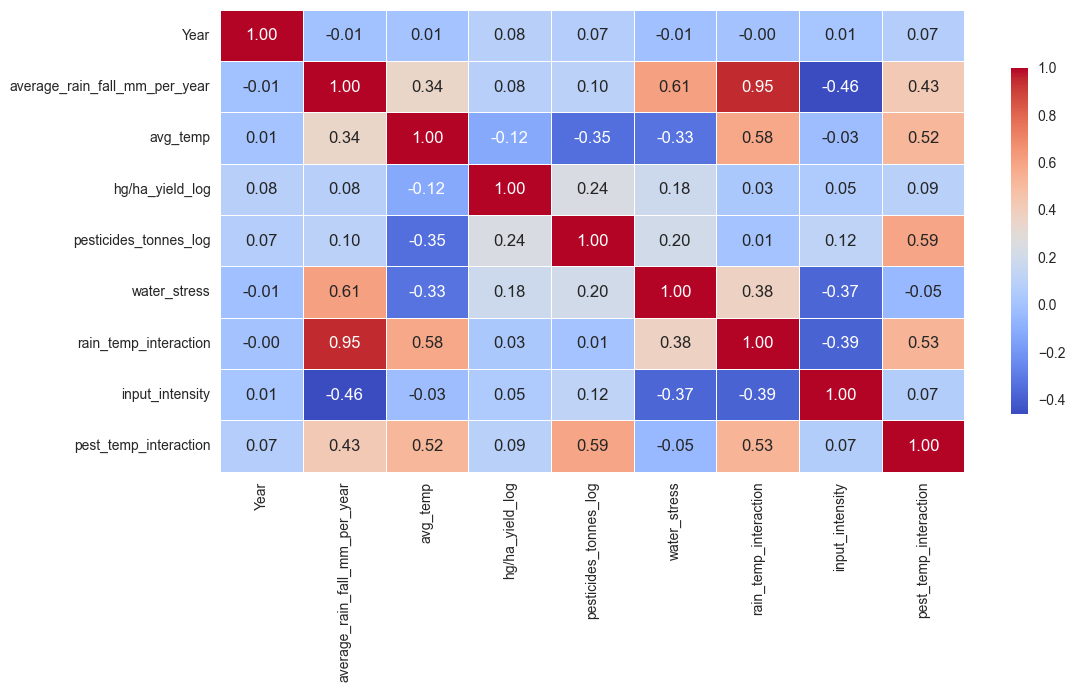

In [14]:
# commençons par les variables numériques
plt.figure(figsize=(12,6))
sns.heatmap(data=yield_df[num_vars].corr(method='pearson'),fmt='.2f',linewidths=0.5,cmap='coolwarm',cbar_kws={'shrink': 0.75}, annot=True)
plt.show()

* Nous observons que quelques variables sont redondantes, mais c'est normal car issue de feature engineering, nous allons faire un filtrage après avec un selectkbest dans notre pipeline de modelisation

In [15]:
target = 'hg/ha_yield_log'

In [16]:
for cat in cat_vars:
    # groupons par modalité de la variable catégorielle
    groups = [
        grp[target].values
        for _, grp in yield_df.groupby(cat)
        if len(grp[target].dropna()) > 0
    ]

    # exécution de l'ANOVA
    anova_result = f_oneway(*groups)

    # affichons les résultats
    title = f"{target} vs {cat}"
    if anova_result.pvalue > 0.05:
        print(f"{title} -> pas d'effet significatif "
              f"(F={anova_result.statistic:.2f}, p={anova_result.pvalue:.6f})")
    else:
        print(f"{title} -> effet significatif "
              f"(F={anova_result.statistic:.2f}, p={anova_result.pvalue:.6f})")

hg/ha_yield_log vs Area -> effet significatif (F=38.49, p=0.000000)
hg/ha_yield_log vs Item -> effet significatif (F=2021.16, p=0.000000)
hg/ha_yield_log vs climate_cluster -> effet significatif (F=281.88, p=0.000000)


* Nous observons l'utilisation des pesticides à un petit facteur sur le rendement
* Les rendements moyens ne sont pas les même entre les pays
* Et aussi que les cultures ont des rendements structurellement différents
* Le climat joue un facteur très important

In [17]:
# Choix du type d'encodage en fonction de la variable
# Commençons par Item (cultures)
(yield_df['Item'].value_counts())

Item
Potatoes                2091
Maize                   2028
Wheat                   1810
Rice, paddy             1502
Sorghum                 1435
Soybeans                1242
Sweet potatoes          1163
Cassava                  941
Plantains and others     464
Yams                     454
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Item'>

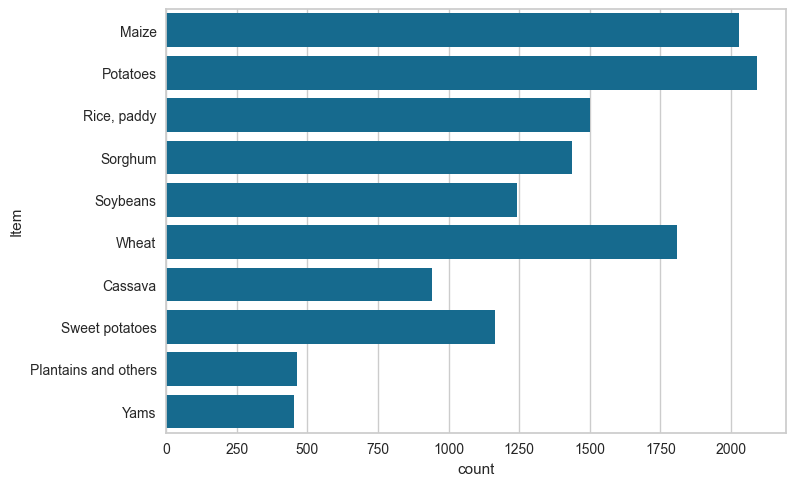

In [18]:
sns.countplot(yield_df['Item'])

* comme cette vairiable contient 10 catégories, toutes nominales (pas d’ordre naturel) et bien réparties (pas de catégorie ultra rare) et vais l'encoder en onehot (OneHotEncoder)

In [19]:
# Maintenant passons à area
yield_df['Area'].value_counts()

Area
Cameroon      230
Kenya         230
Colombia      207
Brazil        207
Burundi       207
             ... 
Latvia         42
Belgium        39
Bahrain        29
Montenegro     24
Sudan          14
Name: count, Length: 101, dtype: int64

* Les pays sont nominales aussi (pas d'ordre), forte catégorielle (à haute cardinalité) mais aussi stable. Je vais utilisé du onehot aussi pour evité la fuite de donnée avec un targetencoding (même chose pour cluster_climate)

## Preprocessing

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [21]:
# separation des données
X = yield_df.drop(columns=[target])
y = yield_df[target]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [23]:
num_vars = X_train.select_dtypes(include=np.number).columns.tolist()
num_vars.remove("climate_cluster")
cat_vars = X_train.select_dtypes(exclude=np.number).columns.tolist()
cat_vars.append("climate_cluster")
print('Variables Catégorielles :', cat_vars)
print('Variables Numérique', len(num_vars), ':', num_vars)

Variables Catégorielles : ['Area', 'Item', 'climate_cluster']
Variables Numérique 8 : ['Year', 'average_rain_fall_mm_per_year', 'avg_temp', 'pesticides_tonnes_log', 'water_stress', 'rain_temp_interaction', 'input_intensity', 'pest_temp_interaction']


In [24]:
# Nous allons definir notre preprocesseur
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown="ignore", drop='first'), cat_vars ),
    ('num', StandardScaler(), num_vars)
    ])

## Modelisation

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, median_absolute_error
)
from sklearn.model_selection import LearningCurveDisplay
from sklearn.feature_selection import VarianceThreshold

# enregistrons l'expérience sur mlflow
import mlflow
import mlflow.sklearn

In [44]:
#fonction d'evaluation
def evaluation(model, X_train, y_train, X_test, y_test, scorer='r2', cv=4):

    # Prédictions
    y_pred = model.predict(X_test)

    # Métriques
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": rmse,
        "R2": r2_score(y_test, y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred),
        "MedAE": median_absolute_error(y_test, y_pred),
        "RRMSE (%)": 100 * rmse / y_test.mean()
    }

    print("\n=== MÉTRIQUES ===")
    for k, v in metrics.items():
        print(f"{k:17s}: {v:.4f}")

    # Courbe d'apprentissage
    plt.figure(figsize=(12,6))
    LearningCurveDisplay.from_estimator(model, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)
    plt.title(f"Learning Curve ({scorer})")
    plt.tight_layout()
    plt.show();

### Model Linear

In [45]:
linear_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('estimator', LinearRegression())
])

In [47]:
# initialisation de mlflow
mlflow.set_experiment("Agriculture Yield Prediction")

<Experiment: artifact_location='file:c:/Users/laelo/Desktop/Appli_Agriculture/notebooks/mlruns/1', creation_time=1771952162237, experiment_id='1', last_update_time=1771952162237, lifecycle_stage='active', name='Agriculture Yield Prediction', tags={}, workspace='default'>

In [49]:
mlflow.sklearn.autolog()
with mlflow.start_run(run_name="Linear Regression Baseline"):
    linear_model.fit(X_train, y_train)

2026/02/24 18:14:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\laelo\Desktop\Appli_Agriculture\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/02/24 18:14:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\laelo\Desktop\Appli_Agri

2026/02/24 18:15:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\laelo\Desktop\Appli_Agriculture\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."



=== MÉTRIQUES ===
MAE              : 0.3866
MSE              : 0.2690
RMSE             : 0.5187
R2               : 0.7968
MAPE             : 0.0381
MedAE            : 0.2919
RRMSE (%)        : 4.8916


<Figure size 1200x600 with 0 Axes>

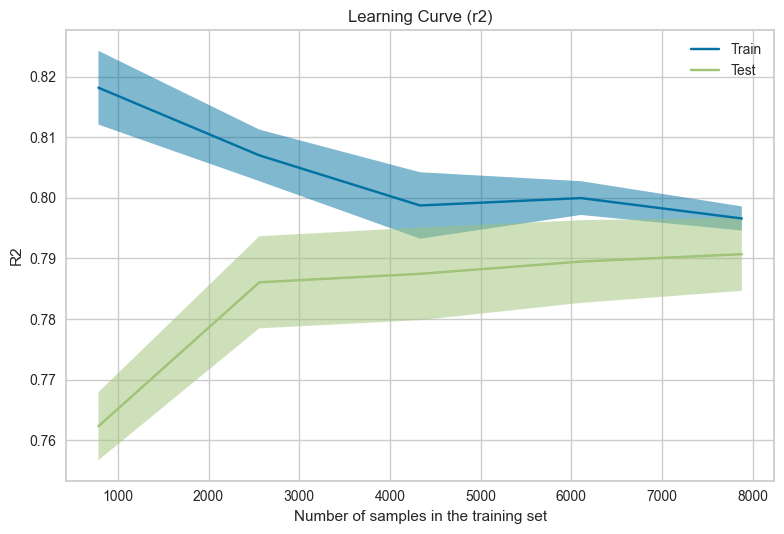

In [50]:
# evaluons notre premier model
evaluation(linear_model, X_train, y_train, X_test, y_test)

* Model a Base d'Abres

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
forest_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('estimator', RandomForestRegressor(random_state=44))
])

In [53]:
with mlflow.start_run(run_name="Random Forest Baseline"):
    forest_model.fit(X_train, y_train)

2026/02/24 18:17:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\laelo\Desktop\Appli_Agriculture\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/02/24 18:18:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\laelo\Desktop\Appli_Agri

2026/02/24 18:18:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\laelo\Desktop\Appli_Agriculture\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."



=== MÉTRIQUES ===
MAE              : 0.1450
MSE              : 0.0595
RMSE             : 0.2439
R2               : 0.9551
MAPE             : 0.0145
MedAE            : 0.0800
RRMSE (%)        : 2.3000


<Figure size 1200x600 with 0 Axes>

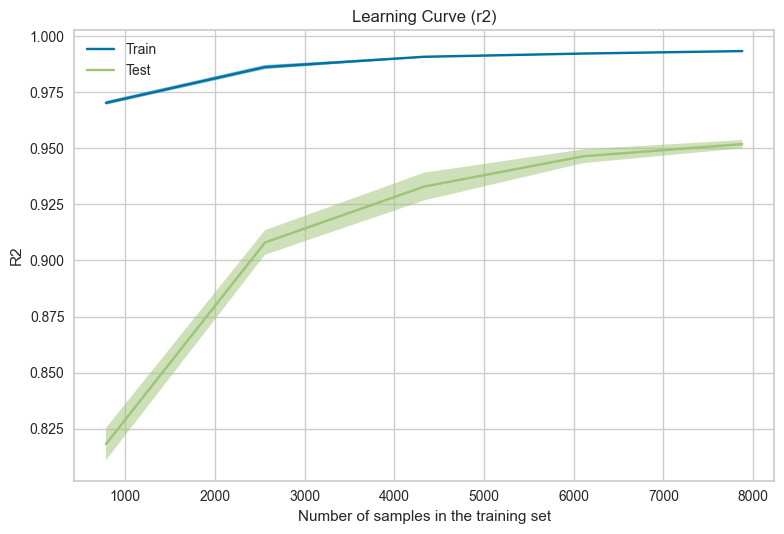

In [54]:
evaluation(forest_model, X_train, y_train, X_test, y_test)

## Optimisation de modèle

In [35]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [36]:
param_grid = {
    "estimator__n_estimators": [200, 400, 800],
    "estimator__max_depth": [10, 20, 30, None],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 4],
    "estimator__max_features": ["sqrt", "log2", 0.5],
    "estimator__bootstrap": [True, False] }

In [37]:
help(HalvingGridSearchCV)

Help on class HalvingGridSearchCV in module sklearn.model_selection._search_successive_halving:

class HalvingGridSearchCV(BaseSuccessiveHalving)
 |  HalvingGridSearchCV(estimator, param_grid, *, factor=3, resource='n_samples', max_resources='auto', min_resources='exhaust', aggressive_elimination=False, cv=5, scoring=None, refit=True, error_score=nan, return_train_score=True, random_state=None, n_jobs=None, verbose=0)
 |
 |  Search over specified parameter values with successive halving.
 |
 |  The search strategy starts evaluating all the candidates with a small
 |  amount of resources and iteratively selects the best candidates, using
 |  more and more resources.
 |
 |  Read more in the :ref:`User guide <successive_halving_user_guide>`.
 |
 |  .. note::
 |
 |    This estimator is still **experimental** for now: the predictions
 |    and the API might change without any deprecation cycle. To use it,
 |    you need to explicitly import ``enable_halving_search_cv``::
 |
 |      >>> # ex

In [38]:
halving = HalvingGridSearchCV(
    estimator=forest_model,
    param_grid=param_grid,
    factor=3,
    scoring="neg_root_mean_squared_error",
    refit=True,
    cv=3,
    verbose=2,
    n_jobs=-1
)
halving.fit(X_train, y_train)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 43
max_resources_: 10504
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 648
n_resources: 43
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
----------
iter: 1
n_candidates: 216
n_resources: 129
Fitting 3 folds for each of 216 candidates, totalling 648 fits
----------
iter: 2
n_candidates: 72
n_resources: 387
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 3
n_candidates: 24
n_resources: 1161
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 4
n_candidates: 8
n_resources: 3483
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 5
n_candidates: 3
n_resources: 10449
Fitting 3 folds for each of 3 candidates, totalling 9 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=44))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (string) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'estimator__bootstrap': [True, False], 'estimator__max_depth': [10, 20, ...], 'estimator__max_features': ['sqrt', 'log2', ...], 'estimator__min_samples_leaf': [1, 2, ...], ...}"
,"factor factor: int or float, default=3The 'halving' parameter, which determines the proportion of candidatesthat are selected for each subsequent iteration. For example,``factor=3`` means that only one third of the candidates are selected.",3
,"resource resource: ``'n_samples'`` or str, default='n_samples'Defines the resource that increases with each iteration. By default,the resource is the number of samples. It can also be set to anyparameter of the base estimator that accepts positive integervalues, e.g. 'n_iterations' or 'n_estimators' for a gradientboosting estimator. In this case ``max_resources`` cannot be 'auto'and must be set explicitly.",'n_samples'
,"max_resources max_resources: int, default='auto'The maximum amount of resource that any candidate is allowed to usefor a given iteration. By default, this is set to ``n_samples`` when``resource='n_samples'`` (default), else an error is raised.",'auto'
,"min_resources min_resources: {'exhaust', 'smallest'} or int, default='exhaust'The minimum amount of resource that any candidate is allowed to usefor a given iteration. Equivalently, this defines the amount ofresources `r0` that are allocated for each candidate at the firstiteration.- 'smallest' is a heuristic that sets `r0` to a small value: - ``n_splits * 2`` when ``resource='n_samples'`` for a regression problem - ``n_classes * n_splits * 2`` when ``resource='n_samples'`` for a classification problem - ``1`` when ``resource != 'n_samples'``- 'exhaust' will set `r0` such that the **last** iteration uses as much resources as possible. Namely, the last iteration will use the highest value smaller than ``max_resources`` that is a multiple of both ``min_resources`` and ``factor``. In general, using 'exhaust' leads to a more accurate estimator, but is slightly more time consuming.Note that the amount of resources used at each iteration is always amultiple of ``min_resources``.",'exhaust'
,"aggressive_elimination aggressive_elimination: bool, default=FalseThis is only relevant in cases where there isn't enough resources toreduce the remaining candidates to at most `factor` after the lastiteration. If ``True``, then the search process will 'replay' thefirst iteration for as long as needed until the number of candidatesis small enough. This is ``False`` by default, which means that thelast iteration may evaluate more than ``factor`` candidates. See:ref:`aggressive_elimination` for more details.",False
,"cv cv: int, cross-validation generator or iterable, default=5Determines the cross-validation splitting strategy.Possible inputs for cv are:- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... note:: Due to implementation details, the folds produced by `cv` must be the same across multiple calls to `cv.split()`. For built-in `scikit-learn` iterators, this ca

In [39]:
print("Meilleurs paramètres :", halving.best_params_)
print("Meilleur score CV :", halving.best_score_)

Meilleurs paramètres : {'estimator__bootstrap': False, 'estimator__max_depth': 30, 'estimator__max_features': 0.5, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 800}
Meilleur score CV : -0.2501676931251418



=== MÉTRIQUES ===
MAE              : 0.1435
MSE              : 0.0585
RMSE             : 0.2418
R2               : 0.9558
MAPE             : 0.0144
MedAE            : 0.0784
RRMSE (%)        : 2.2806


<Figure size 1200x600 with 0 Axes>

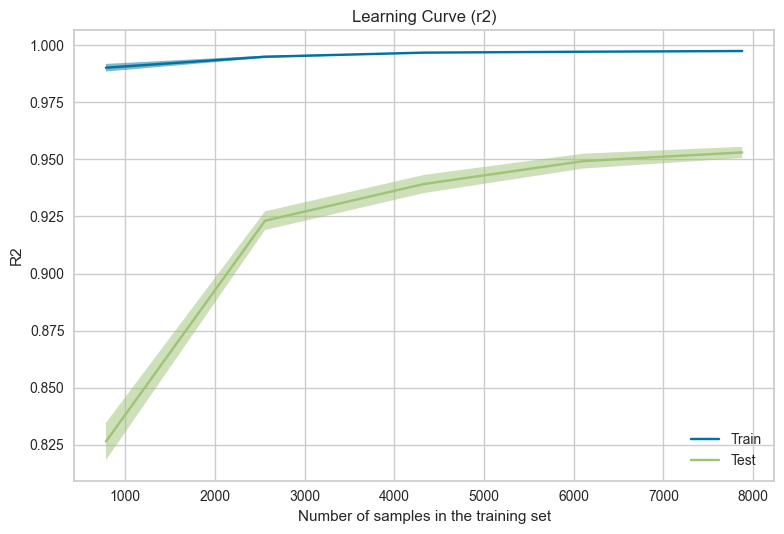

In [40]:
evaluation(halving.best_estimator_, X_train, y_train, X_test, y_test)

## Explicabilité

In [40]:
import shap

In [41]:
best_model = halving.best_estimator_
best_model.steps

[('preprocess',
  ColumnTransformer(transformers=[('cat',
                                   OneHotEncoder(drop='first',
                                                 handle_unknown='ignore'),
                                   ['Area', 'Item', 'climate_cluster']),
                                  ('num', StandardScaler(),
                                   ['Year', 'average_rain_fall_mm_per_year',
                                    'avg_temp', 'pesticides_tonnes_log',
                                    'water_stress', 'rain_temp_interaction',
                                    'input_intensity',
                                    'pest_temp_interaction'])])),
 ('estimator',
  RandomForestRegressor(bootstrap=False, max_depth=30, max_features=0.5,
                        min_samples_leaf=2, min_samples_split=5, n_estimators=400,
                        random_state=44))]

In [42]:
preprocess = best_model.named_steps['preprocess']
rf = best_model.named_steps['estimator']

In [43]:
# Extraction des variables
feature_names = preprocess.get_feature_names_out()

In [44]:
X_pre = preprocess.transform(X_train)
X_pre


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 111976 stored elements and shape (10504, 121)>

In [45]:
# Convertissons en dense car c'est un sparse matrix
X_pre = X_pre.toarray()
# Convertir en float64
X_pre = X_pre.astype("float64")
X_pre

array([[ 0.        ,  0.        ,  0.        , ...,  0.1702503 ,
        -0.40238964, -0.55190967],
       [ 0.        ,  0.        ,  0.        , ...,  0.48052036,
        -0.46061229, -0.95839342],
       [ 0.        ,  0.        ,  0.        , ...,  0.15883284,
        -0.14163387,  2.31088712],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.11755859,
        -0.38138166,  1.02934824],
       [ 0.        ,  0.        ,  0.        , ..., -0.68892504,
        -0.25858313, -1.03241626],
       [ 0.        ,  0.        ,  0.        , ..., -0.96528875,
        -0.08575257, -1.37545795]])

In [46]:
# Échantillonnons pour SHAP pour une question de rapidité
X_sample = X_pre[:1000]
# On utilise un échantillon plus petit pour le "background" (100 est souvent suffisant)
background_data = shap.sample(X_pre, 100)

In [47]:
# créons l'explainer shap
explainer = shap.TreeExplainer(rf, data=background_data)
shap_values = explainer.shap_values(X_sample, check_additivity=False)

100%|===================| 999/1000 [06:43<00:00]       

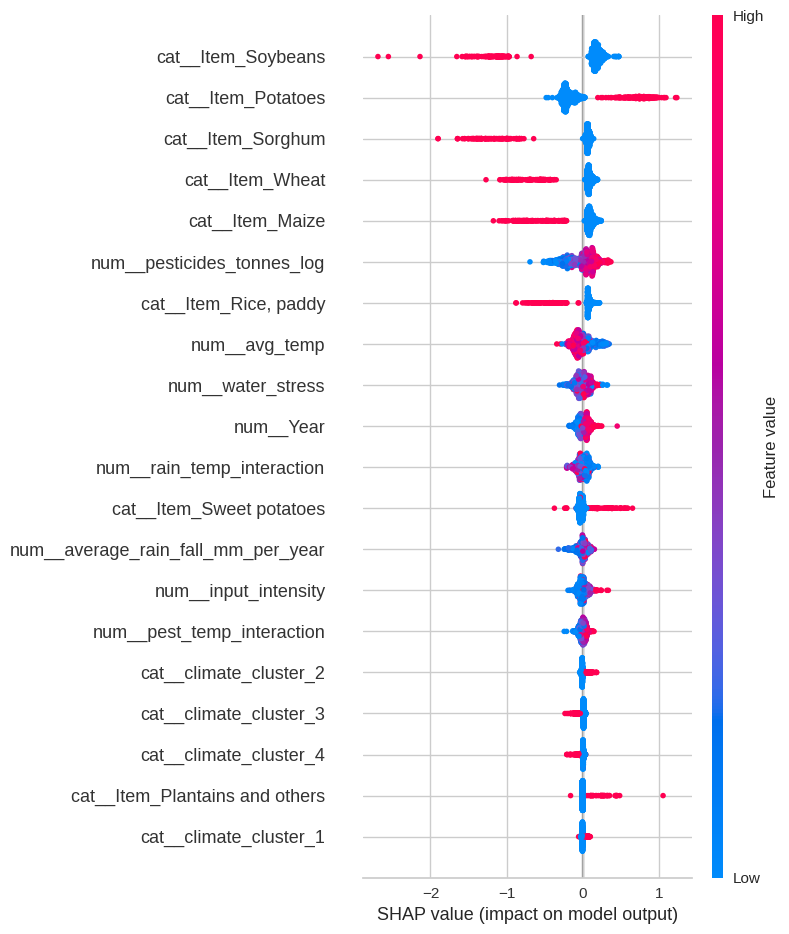

In [48]:
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

## Sauvegarde pour la production

In [73]:
import joblib
import json

In [42]:
print(halving.best_params_)

{'estimator__bootstrap': False, 'estimator__max_depth': 30, 'estimator__max_features': 0.5, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 800}


In [74]:
# comme nous avons validé les différents paramètre du model
# Nous allons l'entrainné avec tout nos données disponibles (mais les metrics seront ceux deja validé)
forest_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('estimator', RandomForestRegressor(n_estimators=800, bootstrap=False, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=5, random_state=44))
])
forest_model.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('estimator', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers 

In [75]:
# sauvegarde du pipeline (preprocessing + model)
joblib.dump(forest_model, '../model_artifacts/final_model.pkl')

['../model_artifacts/final_model.pkl']

In [76]:
country_stats.reset_index(inplace=True)

In [77]:
# Nous allons sauvegarder aussi le mapping appris au niveau de climate_clucters
# un dictionnaire de correspondance
country_to_cluster = dict(zip(country_stats['Area'], country_stats['climate_cluster']))
joblib.dump(country_to_cluster, '../model_artifacts/country_to_cluster.pkl')

['../model_artifacts/country_to_cluster.pkl']

In [78]:
# sauvegardons les metadonnées autours du model
hyp_params = forest_model.named_steps["estimator"].get_params()
inp_col = X.columns.tolist()

In [82]:
mae = float(np.expm1(0.14))
rmse = float(np.expm1(0.24))

In [ ]:
metadata = {
    "author": 'Abdourahamane',
    'trained_on': "28-01-2026",
    "dataset_version": "yield_data",
    "metrics": {
        "MAE" : mae,
        "RMSE" : rmse,
        "R2" : 0.96
    },
    "hyperparameters": hyp_params,
    'input_columns': inp_col

}

with open("../model_artifacts/metadata.json", "w") as f:
  json.dump(metadata, f, indent=4)

In [80]:
# sauvegardonc aussi les pays et items disp
countries = X.Area.unique().tolist()
farming = X.Item.unique().tolist()
cat_info ={
    "Areas": countries,
    'Items': farming
}

In [81]:
with open("../model_artifacts/cat_info.json", 'w') as f:
    json.dump(cat_info, f, indent=4)